# Deep Hedging with a simple structure in the presence of market impact

In another notebook we showed that the hedging performance for a neural network with a simple structure, i.e. $\delta^\theta_k = F^{\theta_k}(I_k)$, is similar compared to the semi-recurrent structure $\delta^\theta_k = F^{\theta_k}(I_k, \delta^\theta_{k-1})$.
This, however, is not true anymore if we assume the presence of market frictions.
Thus, the purpose of this notebook is to do a similar experiment but with the presence of permanent price impact.

---

We first consider the Bachelier model **without market impact**.
The dynamics are given by

$$dS_t = S_0\mu dt + S_0\sigma dW_t.$$

The no-arbitrage price of a call option on $S$ with strike $K > 0$ and maturity $T > 0$ is given by

$$C_t = \left(S_t-K\right) \Phi\left(\frac{S_t-K}{S_0 \sigma \sqrt{T-t}}\right)+S_0 \sigma \sqrt{T-t} \varphi\left(\frac{S_t-K}{S_0 \sigma \sqrt{T-t}}\right).$$

Moreover, the $\Delta$-hedging strategy is given by

$$\delta_t = u_x(t, S_t) = \Phi\left(\frac{S_t-K}{S_0 \sigma \sqrt{T-t}}\right).$$

For the case **with market impact** we have that the perfect hedging strategy $\delta_t$ must satisfy
$$\delta_t = u_x(t, S_t - \delta_t\lambda) = \Phi\left(\frac{S_t - \delta_t\lambda-K}{S_0 \sigma \sqrt{T-t}}\right).$$

Observe that this hedging strategy $\Delta_t$ depends on itself and there is no obvious way to compute $\Delta_t$ directly.
However it can be solved numerically, e.g. using a fixed-point iteration.


## Setup

Next, we import some required packages and our own modules.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

from torch import nn
from torch.optim import Adam

from modules.utils import save_model, compare_hedgers
from modules.market_impact import FixedImpact
from modules.transaction_cost import ZeroCost
from modules.risk_measure import AverageValueAtRisk
from modules.derivative import EuropeanOption
from modules.bachelier import BachelierModel, BachelierHedger, BachelierHedgerFixedImpact
from modules.deep_hedger import DeepHedger, SimpleDeepHedger, train

If a GPU is available, we would like to use the GPU to speed up the training process. \\
Unfortunately, for some reason, training with the GPU is slower than without! \\
For this reason we will use the CPU for now!

In [2]:
# device settings
if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')
print('Device: {}'.format(my_device))

Device: cpu


## Setting

We consider a discretized one-dimensional Bachelier model with model parameters $\mu = 0$, $\sigma = 0.2$ and $s_0 = 100$.
As in the Black-Scholes case, our objective will be to hedge a call option with maturity $T = 30/365$ and strike price $K = s_0$.

In [3]:
# define parameters
d = 1  # number of hedging instruments 
T = 30/365  # maturity
N = 30  # time discretization
dt = T/N  # time step

# Bachelier model parameters
s0 = (100.0)  # inital value(s)
sigma = 0.2  # volatility
model = BachelierModel(initial_value=s0, sigma=sigma, dt=dt, device=my_device)

# derivative to hedge
call = True
strike = s0 
derivative = EuropeanOption(call=call, strike=strike, maturity=T)
price = None

Note that the risk-neutral price can be easily computed using the formula above.

In [4]:
q = BachelierHedger(n_dim=d, n_steps=N, model=model, derivative=derivative, sigma=sigma).price().item()
print('The risk neutral price is given by {:.4f}.'.format(q))

The risk neutral price is given by 2.2875.


We choose $\rho = \text{AVaR}_{\alpha}$ as our risk measure, as this allows to easily model different risk-preferences by adjusting the parameter $\alpha \in (0, 1)$ appropriately.
In particular, for this experiment we choose $\alpha = 0.01$.
Further, we consider fixed market impact with parameter $\lambda = 1$.
We assume no transaction costs, i.e. $C_{T} \equiv 0$.


In [5]:
# risk measure
alpha = 0.01
risk_measure = AverageValueAtRisk(alpha=alpha)

# market impact model
lambd = 1.0
market_impact = FixedImpact(lambd=lambd)

# transaction cost model
c = 0.0
transaction_cost = ZeroCost()

## Training the neural network model


Next, let us specify our training parameters.

We use Adam to optimize our neural network and we choose a learning rate of $\eta = 0.005$ and a batch size of $256$.

In [6]:
# training parameters
n_epochs = 30  # number of epochs (set to 0 for no training)
n_samples = 4*1000000  # number of samples
validation_samples = n_samples // 4  # number of validation samples
batch_size = 256  # batch size
lr = 0.005  # learning rate

In [11]:
path_simple = 'saved_models/deep_hedging_with_impact'  # path to saved models
file_name_simple = 'simple_hedger_impact_bachelier'

use_pretrained_simple = True  # use pre-trained model
saving_model_simple = False  # save model after training

We have implented the hedging strategy with a simple network structure in the class ``SimpleDeepHedger``.

 

In [12]:
simple_hedger_impact = SimpleDeepHedger(n_dim=d, n_steps=N, model=model, market_impact=market_impact, transaction_cost=transaction_cost).to(my_device)
optimizer = Adam(simple_hedger_impact.parameters(), lr=lr)
if use_pretrained_simple:  # load model
    simple_hedger_impact.load_state_dict(torch.load('{}/{}.pth'.format(path_simple, file_name_simple)), strict=False)
    print('model loaded')

model loaded


We can now train our model with the specified training parameters and plot the training and test loss during each epoch.

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

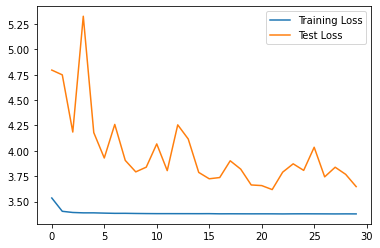

In [ ]:
train_history, test_history = train(simple_hedger_impact, derivative, risk_measure, optimizer, 
                                    price=price, n_samples=n_samples, validation_samples=validation_samples, n_epochs=n_epochs, batch_size=batch_size)
plt.plot(train_history, label='Training Loss')
plt.plot(test_history, label='Test Loss')
plt.legend()
plt.show()

In [ ]:
if saving_model_simple:
    save_model(simple_hedger_impact, file_name_simple, path_simple)
    print('model saved!')

model saved!


Additionally, let us now train the neural network hedging strategy with the semi-recurrent structure.
Therefore, we consider the same training parameters as above.

In [13]:
path_recurrent = 'saved_models/deep_hedging_with_impact'  # path to saved models
file_name_recurrent = 'recurrent_hedger_impact_bachelier'

use_pretrained_recurrent = True  # use pre-trained model
saving_model_recurrent = False  # save model after training

In [14]:
recurrent_hedger_impact = DeepHedger(n_dim=d, n_steps=N, model=model, market_impact=market_impact, transaction_cost=transaction_cost).to(my_device)
optimizer = Adam(recurrent_hedger_impact.parameters(), lr=lr)
if use_pretrained_recurrent:  # load model
    recurrent_hedger_impact.load_state_dict(torch.load('{}/{}.pth'.format(path_recurrent, file_name_recurrent)), strict=False)
    print('model loaded')

model loaded


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

  0%|          | 0/15625 [00:00<?, ?batch/s]

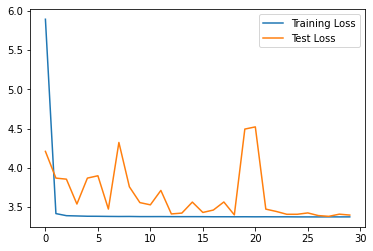

In [10]:
train_history, test_history = train(recurrent_hedger_impact, derivative, risk_measure, optimizer, 
                                    price=price, n_samples=n_samples, validation_samples=validation_samples, n_epochs=n_epochs, batch_size=batch_size)
plt.plot(train_history, label='Training Loss')
plt.plot(test_history, label='Test Loss')
plt.legend()
plt.show()

In [11]:
if saving_model_recurrent:
    save_model(recurrent_hedger_impact, file_name_recurrent, path_recurrent)
    print('model saved!')

model saved!


## Results

First, let us compare the computed prices for the call options.
The hedging strategy with a simple structure yields:

In [15]:
p_0_simple = simple_hedger_impact.price(derivative=derivative, risk_measure=risk_measure, n_samples=validation_samples)
print('The computed price for p_0 is {:.4f}.'.format(p_0_simple))

The computed price for p_0 is 3.6423.


In comparison, the neural network hedging strategy with a semi-recurrent structure yields:

In [16]:
p_0_recurrent = recurrent_hedger_impact.price(derivative=derivative, risk_measure=risk_measure, n_samples=validation_samples)
print('The computed price for p_0 is {:.4f}.'.format(p_0_recurrent))

The computed price for p_0 is 3.3951.


We can now compare the hedging performance for both neural network structures.

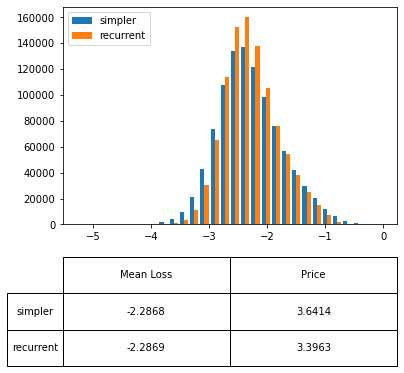

In [17]:
hedgers=[simple_hedger_impact, recurrent_hedger_impact]
labels = ['simpler', 'recurrent']
prices = None
risk_measures = risk_measure
table_labels = ['Price']

compare_hedgers(hedgers=hedgers, model=model, derivative=derivative,
                risk_measure=risk_measures, n_samples=validation_samples, price=prices, 
                labels=labels, table_labels=table_labels, table=True)

We observe that even in the presence of permanent price impact the hedging error for $\delta^{\text{B}}$ and $\delta^{\theta}$ is very similar.
